In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from benchmark import load_chembl,  benchmark, ligand_level_performance
%matplotlib inline

In [2]:
data = load_chembl('stats7', 'best_mcss')

F2
B2AR
B1AR
CHK1
PLK1
PYGM
P00760
CHRM3
CDK2
PTPN1
SMO
JAK2
F10
NR3C1
F11
5HT2B
NR3C2
ERA
MGLUR5
SIGMAR1
BACE1
ELANE
GLUT1
MAPK14
PLAU
AR
PDE10A
MEK1
TRPV1
HSP90AA1
BRAF
A2AR
SLC6A4
VDR
BRD4
DAT
DHFR


In [3]:
def performance(results):
    x, y = [], []
    for prot, ligs in results.items():
        for lig, (combind, glide, best) in ligs.items():
            x += [glide]
            y += [combind]
    return (sum(x) / float(len(x)), sum(np.array(x) <= 2.0) /  float(len(x)),
            sum(y) / float(len(y)), sum(np.array(y) <= 2.0) /  float(len(y)))

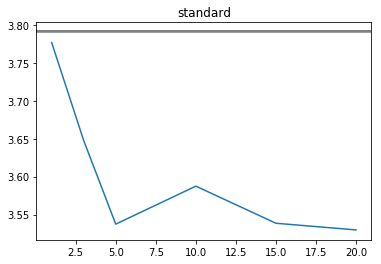

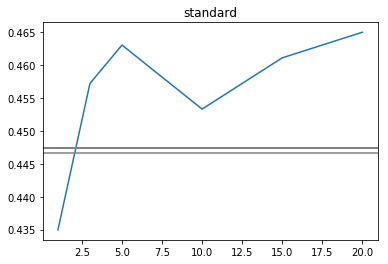

In [4]:
def sweep(data, mode, feature):
    num_ligs = sorted(set(k[0] for k in data[mode].keys()))
    alpha_factor = 1.0
    performances = []
    for n in num_ligs:
        performances += [performance(data[mode][(n, alpha_factor, feature)])]
    plt.plot(num_ligs, [p[2] for p in performances])
    for p in performances:
        plt.axhline(p[0], c = 'grey')
    plt.title(mode)
    plt.show()
    
    plt.plot(num_ligs, [p[3] for p in performances])
    for p in performances:
        plt.axhline(p[1], c = 'grey')
    plt.title(mode)
    plt.show()

sweep(data, 'standard', 'mcss_contact_hbond_sb')

In [5]:
def drug_average(n):
    families = {
        'GPCR': ['5HT2B', 'A2AR', 'B1AR', 'B2AR', 'CHRM3','SMO', 'MGLUR5'],
        'Kinase': ['BRAF', 'CDK2', 'CHK1', 'JAK2', 'PLK1', 'MAPK14', 'MEK1'],
        #'Ion Channel': ['TRPV1'],
        'Transporter': ['SLC6A4', 'GLUT1', 'DAT'],
        'Nuclear Receptor': ['NR3C2', 'NR3C1', 'AR', 'VDR', 'ERA'],
        'Peptidase': ['F2', 'F10', 'F11', 'PLAU', 'P00760', 'BACE1'],
        'Other': ['PYGM', 'PTPN1', 'BRD4', 'HSP90AA1', 'PDE10A', 'SIGMAR1', 'ELANE', 'TRPV1']
    }
    targets = {'GPCR': 0.33,
               'Kinase': 0.03,
               #'Ion Channel': 0.18,
               'Nuclear Receptor': 0.16,
               'Other': 0.20+0.18,
               'Peptidase': 0.03,
               'Transporter': 0.07}

    g_t, c_t, b_t = 0, 0, 0
    for family, members in families.items():
        glide, combind, best = ligand_level_performance(data['standard'][(n, 1.0, 'mcss_contact_hbond_sb')], members, correct_only = True)
        glide, combind, best = np.mean(np.array(glide) < 2.0), np.mean(np.array(combind) < 2.0), np.mean(np.array(best) < 2.0)
        print(family, targets[family], glide, combind, best)
        
        g_t += targets[family] * glide
        c_t += targets[family] * combind
        b_t += targets[family] * best
    print(g_t, c_t, b_t)
      
for n in [20]:
    print(n)
    drug_average(n)

20
GPCR 0.33 0.375 0.5 1.0
Kinase 0.03 0.7340425531914894 0.6914893617021277 1.0
Transporter 0.07 0.5 0.5833333333333334 1.0
Nuclear Receptor 0.16 0.896551724137931 0.896551724137931 1.0
Peptidase 0.03 0.5428571428571428 0.5571428571428572 1.0
Other 0.38 0.5526315789473685 0.6578947368421053 1.0
0.550505266743528 0.6367405757607518 1.0


In [6]:
print((0.48203861147015037 - 0.40942238707989015) / (0.7585791427840918 - 0.40942238707989015))

0.20797599703835942


In [7]:
print(0.4166666666666667 / 0.3125)
print(0.5714285714285714 / 0.42857142857142855)
print(0.4727272727272727 / 0.38181818181818183)

1.3333333333333335
1.3333333333333333
1.238095238095238


363 valid ligands
Ttest_relResult(statistic=1.347870986391345, pvalue=0.1785427500349637)
ComBind improves pose for 57 of 363 ligands
ComBind degrades pose for 43 of 363 ligands
All Ligands RMSD Glide: 2.342741348885946, 0.6336088154269972
All Ligands RMSD ComBind: 2.2031029561340962, 0.6584022038567493


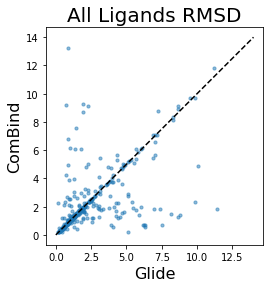

Mean RMSD Glide: 2.4819800812299384
Mean RMSD ComBind: 2.3389413636721286


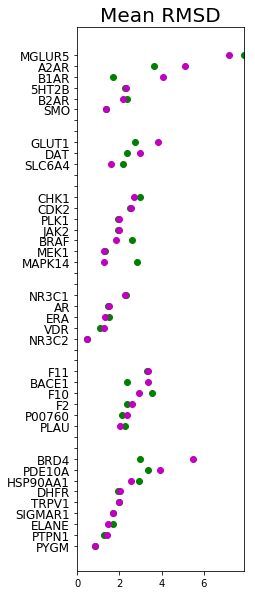

Fraction Near-Native Glide: 0.6004303897331503
Fraction Near-Native ComBind: 0.6297703699761235


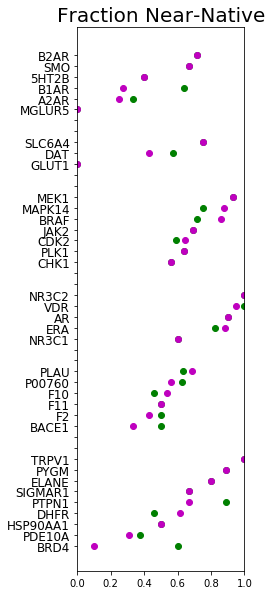

In [8]:
benchmark(data['standard'][(20, 1.0, 'mcss_contact_hbond_sb')], correct_only=True)

363 valid ligands
Ttest_relResult(statistic=1.888083504555954, pvalue=0.05981421225281916)
ComBind improves pose for 45 of 363 ligands
ComBind degrades pose for 30 of 363 ligands
All Ligands RMSD Glide: 2.342741348885946, 0.6336088154269972
All Ligands RMSD ComBind: 2.1877708787213983, 0.6749311294765841


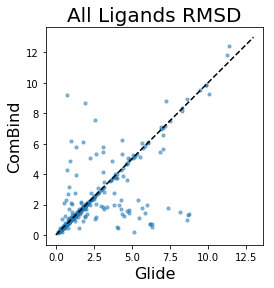

Mean RMSD Glide: 2.4819800812299384
Mean RMSD ComBind: 2.339008214480006


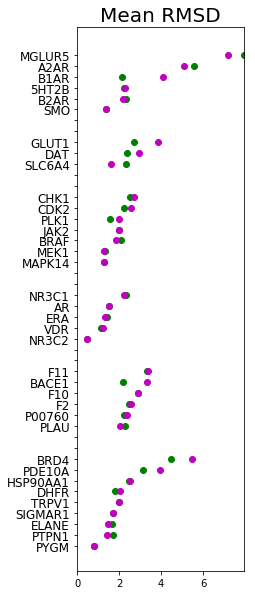

Fraction Near-Native Glide: 0.6004303897331503
Fraction Near-Native ComBind: 0.6424385115658336


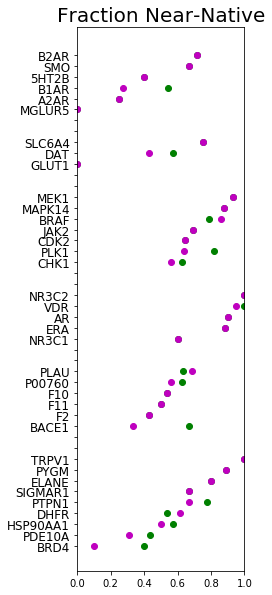

In [9]:
benchmark(data['standard'][(20, 2.0, 'mcss_contact_hbond_sb')], correct_only=True)

514 valid ligands
Ttest_relResult(statistic=3.015629430836959, pvalue=0.0026915556698699273)
ComBind improves pose for 98 of 514 ligands
ComBind degrades pose for 59 of 514 ligands
All Ligands RMSD Glide: 3.7921077688601446, 0.4474708171206226
All Ligands RMSD ComBind: 3.529801709966427, 0.4649805447470817


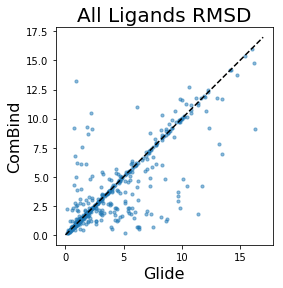

Mean RMSD Glide: 3.6879721646714123
Mean RMSD ComBind: 3.430437272142679


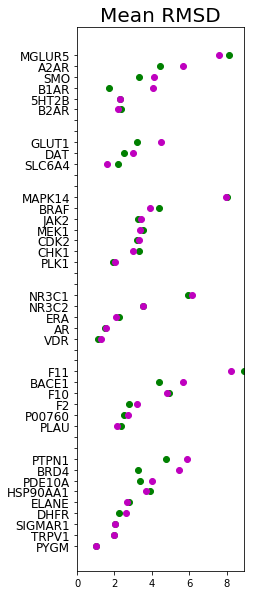

Fraction Near-Native Glide: 0.4535108750182279
Fraction Near-Native ComBind: 0.4746208720473426


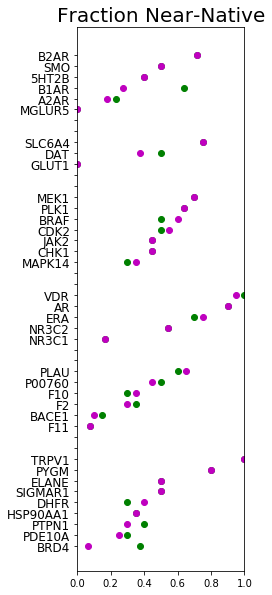

In [10]:
benchmark(data['standard'][(20, 1.0, 'mcss_contact_hbond_sb')])

514 valid ligands
Ttest_relResult(statistic=3.7418696324222083, pvalue=0.00020328299979728624)
ComBind improves pose for 79 of 514 ligands
ComBind degrades pose for 39 of 514 ligands
All Ligands RMSD Glide: 3.7921077688601454, 0.4474708171206226
All Ligands RMSD ComBind: 3.5280732204529044, 0.4766536964980545


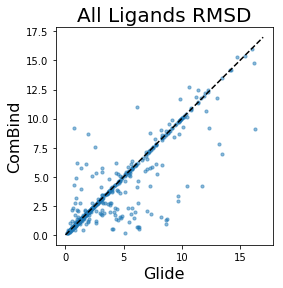

Mean RMSD Glide: 3.6879721646714123
Mean RMSD ComBind: 3.435185801677938


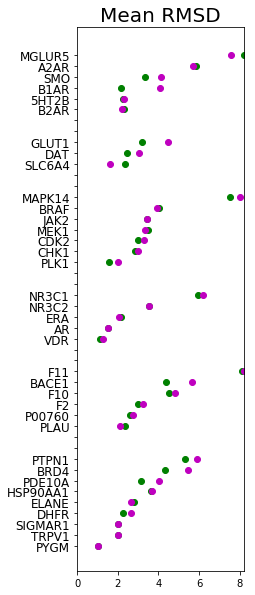

Fraction Near-Native Glide: 0.4535108750182279
Fraction Near-Native ComBind: 0.4831510265333795


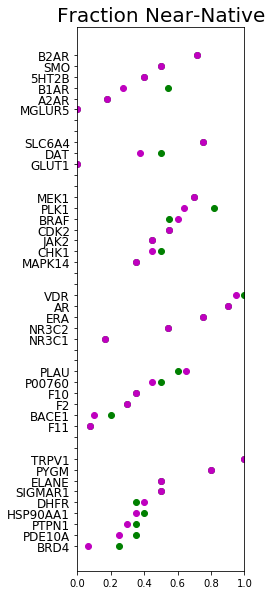

In [11]:
benchmark(data['standard'][(20, 2.0, 'mcss_contact_hbond_sb')])

494 valid ligands
Ttest_relResult(statistic=3.1617356211512093, pvalue=0.0016649067349233631)
ComBind improves pose for 97 of 494 ligands
ComBind degrades pose for 61 of 494 ligands
All Ligands RMSD Glide: 3.6224890921638315, 0.451417004048583
All Ligands RMSD ComBind: 3.3670246423785635, 0.46963562753036436


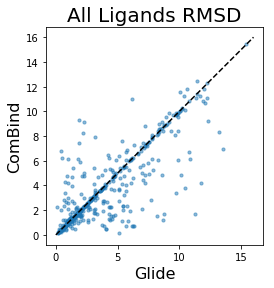

Mean RMSD Glide: 3.5652945384260497
Mean RMSD ComBind: 3.3017038285106772


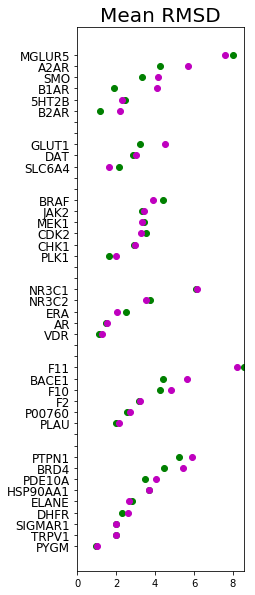

Fraction Near-Native Glide: 0.4564683285901773
Fraction Near-Native ComBind: 0.47710437088588337


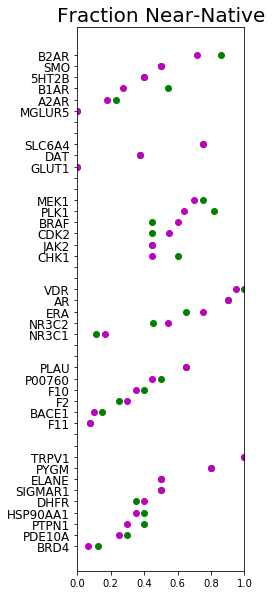

In [12]:
benchmark(data['standard'][(5, 1.0, 'mcss_contact_hbond_sb')], exclude = ['MAPK14'])

141 valid ligands
Ttest_relResult(statistic=2.80216732312073, pvalue=0.005795763611250856)
ComBind improves pose for 33 of 141 ligands
ComBind degrades pose for 21 of 141 ligands
All Ligands RMSD Glide: 2.8723054118130453, 0.5035460992907801
All Ligands RMSD ComBind: 2.3362784128856453, 0.5886524822695035


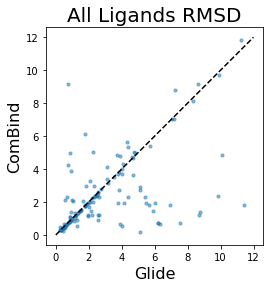

Mean RMSD Glide: 2.8980000343573815
Mean RMSD ComBind: 2.5112862314174027


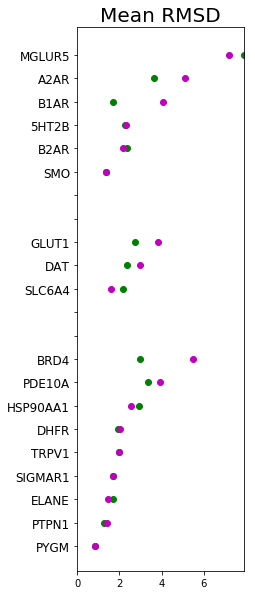

Fraction Near-Native Glide: 0.5017976622143289
Fraction Near-Native ComBind: 0.5696144904478238


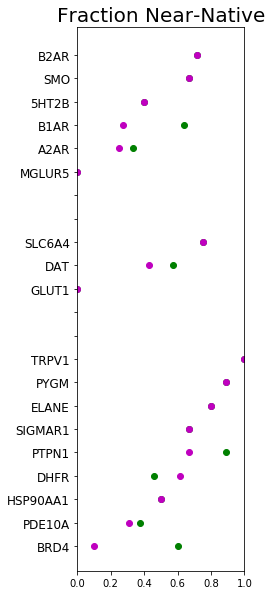

In [13]:
benchmark(data['standard'][(20, 1.0, 'mcss_contact_hbond_sb')],
          families = ['GPCR', 'Transporter', 'Other'],
          correct_only = True)

191 valid ligands
Ttest_relResult(statistic=2.9800114050708175, pvalue=0.0032590387926055096)
ComBind improves pose for 54 of 191 ligands
ComBind degrades pose for 33 of 191 ligands
All Ligands RMSD Glide: 3.7603582302307617, 0.3717277486910995
All Ligands RMSD ComBind: 3.284070279578535, 0.39790575916230364


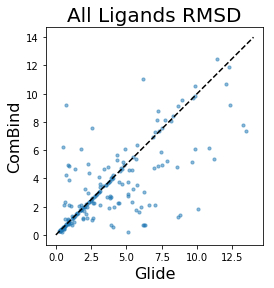

Mean RMSD Glide: 3.58197748126982
Mean RMSD ComBind: 3.225487761991479


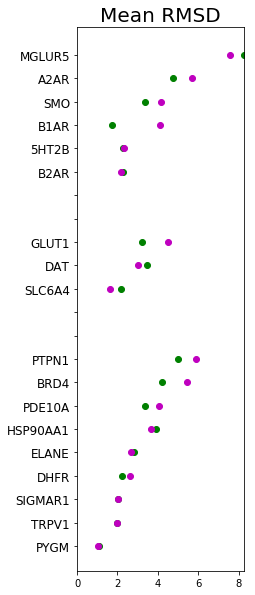

Fraction Near-Native Glide: 0.4083879764026823
Fraction Near-Native ComBind: 0.4263172693319752


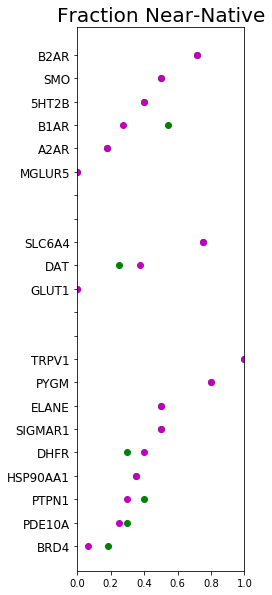

In [14]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['GPCR', 'Transporter', 'Other'])

131 valid ligands
Ttest_relResult(statistic=1.540257340544525, pvalue=0.12592825821364717)
ComBind improves pose for 10 of 131 ligands
ComBind degrades pose for 6 of 131 ligands
All Ligands RMSD Glide: 3.9800432177030927, 0.5267175572519084
All Ligands RMSD ComBind: 3.8491037840626183, 0.5419847328244275


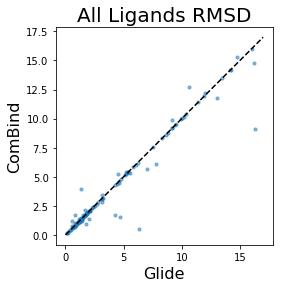

Mean RMSD Glide: 3.853178718436975
Mean RMSD ComBind: 3.70344750866996


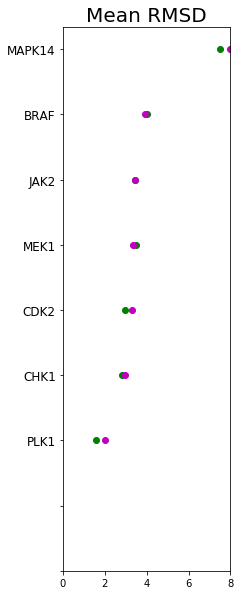

Fraction Near-Native Glide: 0.5337662337662338
Fraction Near-Native ComBind: 0.5597402597402599


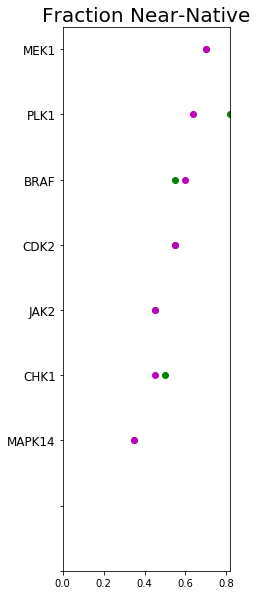

In [15]:
benchmark(data['standard'][(20, 2.0, 'mcss_contact_hbond_sb')],
          families = ['Kinase'])

48 valid ligands
Ttest_relResult(statistic=2.146558610476495, pvalue=0.037020663927393734)
ComBind improves pose for 16 of 48 ligands
ComBind degrades pose for 7 of 48 ligands
All Ligands RMSD Glide: 4.490167492815709, 0.3125
All Ligands RMSD ComBind: 3.6167774925026044, 0.375


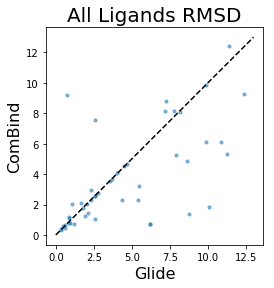

Mean RMSD Glide: 4.332481409113982
Mean RMSD ComBind: 3.773980952598883


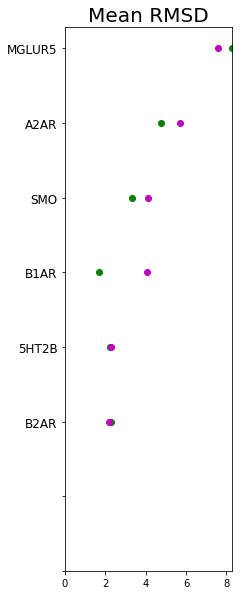

Fraction Near-Native Glide: 0.34391392920804686
Fraction Near-Native ComBind: 0.38936847466259233


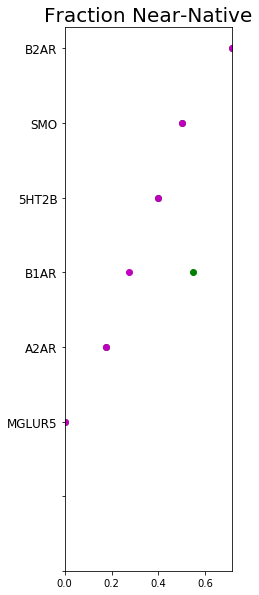

In [16]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['GPCR'])

129 valid ligands
Ttest_relResult(statistic=2.4230493193675677, pvalue=0.016789915776762518)
ComBind improves pose for 34 of 129 ligands
ComBind degrades pose for 22 of 129 ligands
All Ligands RMSD Glide: 3.5896165801317004, 0.3875968992248062
All Ligands RMSD ComBind: 3.1859144228413494, 0.4108527131782946


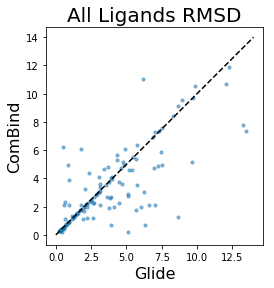

Mean RMSD Glide: 3.2606264906395968
Mean RMSD ComBind: 2.952277967303828


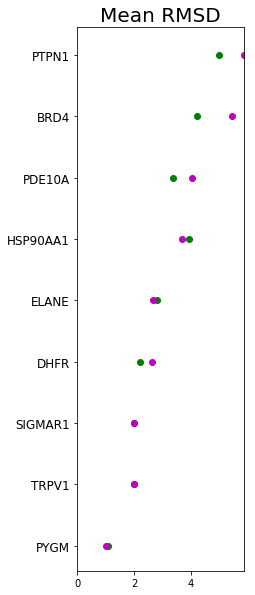

Fraction Near-Native Glide: 0.46249999999999997
Fraction Near-Native ComBind: 0.4819444444444444


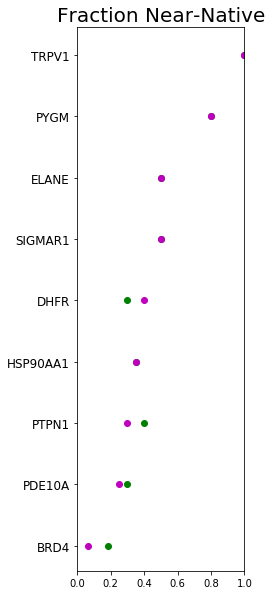

In [17]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['Other'])

113 valid ligands
Ttest_relResult(statistic=1.4211553689141438, pvalue=0.15804993789859315)
ComBind improves pose for 22 of 113 ligands
ComBind degrades pose for 11 of 113 ligands
All Ligands RMSD Glide: 4.230906936664662, 0.336283185840708
All Ligands RMSD ComBind: 3.9607049723647525, 0.35398230088495575


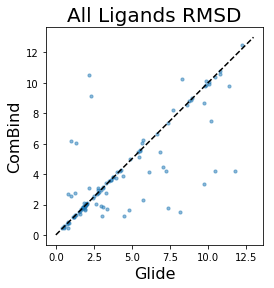

Mean RMSD Glide: 4.463948332651962
Mean RMSD ComBind: 4.230137341123641


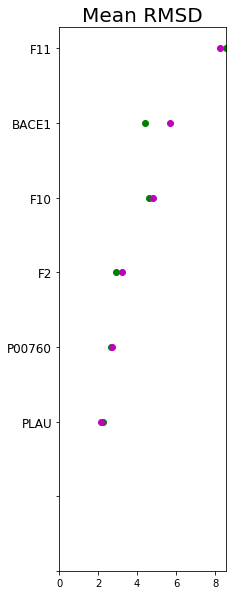

Fraction Near-Native Glide: 0.3211538461538461
Fraction Near-Native ComBind: 0.3378205128205128


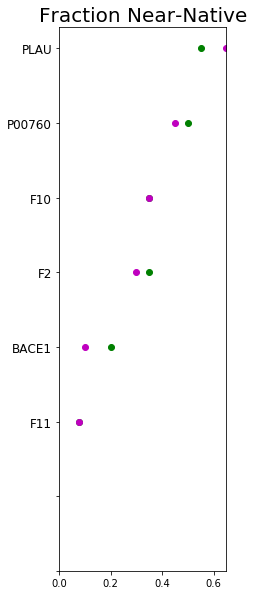

In [18]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['Peptidase'])

14 valid ligands
Ttest_relResult(statistic=-0.32590926702398176, pvalue=0.7496796328009201)
ComBind improves pose for 4 of 14 ligands
ComBind degrades pose for 4 of 14 ligands
All Ligands RMSD Glide: 2.831417391566572, 0.42857142857142855
All Ligands RMSD ComBind: 3.0477959437743567, 0.35714285714285715


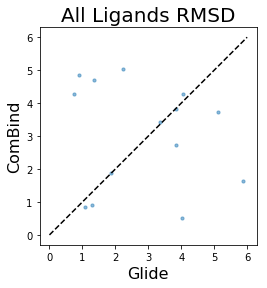

Mean RMSD Glide: 3.0450225974721667
Mean RMSD ComBind: 2.9481307648396253


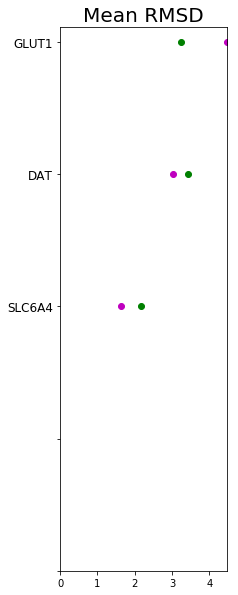

Fraction Near-Native Glide: 0.375
Fraction Near-Native ComBind: 0.3333333333333333


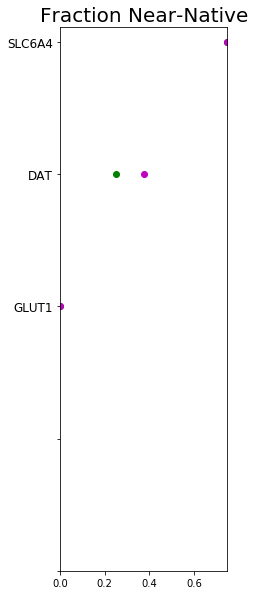

In [19]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['Transporter'])